In [2]:
"""
Purpose: To test the visualizations 
of just takig the average of node features

Psueodocode: 
1) Get the all batch data
2) Average across all of the batches
3) Plot with the given labels

"""

'\nPurpose: To test the visualizations \nof just takig the average of node features\n\nPsueodocode: \n1) Get the all batch data\n2) Average across all of the batches\n3) Plot with the given labels\n\n'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/datasci_tools/datasci_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/graph_tools/graph_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")

import datajoint_utils as du
from importlib import reload

WARNING - 2022-05-06 10:51:46,791 - _default - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.


INFO - 2022-05-06 10:51:49,140 - settings - Setting enable_python_native_blobs to True
INFO - 2022-05-06 10:51:49,141 - settings - Setting stores to {'h01_skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/skeletons', 'stage': '/mnt/dj-stor01/microns/h01/skeletons'}, 'h01_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/meshes', 'stage': '/mnt/dj-stor01/microns/h01/meshes'}, 'h01_faces': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/faces', 'stage': '/mnt/dj-stor01/microns/h01/faces'}, 'h01_decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/decimated_meshes', 'stage': '/mnt/dj-stor01/microns/h01/decimated_meshes'}, 'h01_soma_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/soma_meshes', 'stage': '/mnt/dj-stor01/microns/h01/soma_meshes'}}
INFO - 2022-05-06 10:51:49,155 - connection - Connected celiib@at-database.ad.bcm.edu:3306


Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2022-05-06 10:51:50,214 - settings - Setting enable_python_native_blobs to True
WARNING - 2022-05-06 10:51:53,920 - utils - DataJointPlus version check failed.
INFO - 2022-05-06 10:51:55,610 - settings - Setting enable_python_native_blobs to True
ERROR - 2022-05-06 10:51:55,633 - compatibility - Could not add DataJointPlus to ImportMethod.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info_from_header
    if result[0] == attr:
IndexError: list index out of range
ERROR - 2022-05-06 10:51:55,683 - compatibility - Could not add DataJointPlus to Materialization.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info

In [5]:
from microns_morphology_api.schemas import minnie65_morphology as m65mor
m65mor.config.register_adapters(context=locals())
m65mor.config.register_externals()

from microns_morphology_api.schemas import minnie65_auto_proofreading as m65auto
m65auto.config.register_adapters(context=locals())
m65auto.config.register_externals()

In [6]:
from dataInterfaceMinnie65 import data_interface as hdju

In [7]:
import neuron_nx_utils as nxu
import networkx_utils as xu
import morphopy_utils as mpu

In [8]:
import dimensionality_reduction_ml as dru
import preprocessing_ml as preml
import pandas_ml as pdml
import pandas_utils as pu
import visualizations_ml as vml
import system_utils as su

In [9]:
#datasci_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

# Loading the Data

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cpu


In [11]:
with_skeleton = False

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None

In [12]:
import system_utils as su
data_path = Path("./data/m65_full/")
#list(data_path.iterdir())

gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"

data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134277239760,0,89719,LAYER_6,V1,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
1,864691134339067925,0,624899,LAYER_6,AL,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
2,864691134366116139,0,476756,WHITE_MATTER,RL,"[{'nodelist': ['L0_6'], 'features': ['mesh_vol...",NaN
3,864691134378215335,0,3799,LAYER_2/3,V1,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
4,864691134527727930,0,631380,WHITE_MATTER,RL,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
...,...,...,...,...,...,...,...
60448,864691137197334593,0,376218,LAYER_6,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_5',...",NaN
60449,864691137197344065,0,191436,LAYER_2/3,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_4', 'L0_6',...",NaN
60450,864691137197345345,0,584463,LAYER_2/3,RL,"[{'nodelist': ['L0_13', 'L4_5', 'L0_8', 'L2_5'...",NaN
60451,864691137197353281,0,591241,LAYER_5,RL,"[{'nodelist': ['L4_6', 'L1_10', 'L3_4', 'L0_10...",NaN


In [13]:
meta_data = data_df[["segment_id","split_index"]]
meta_data

,segment_id,split_index
0,864691134277239760,0
1,864691134339067925,0
2,864691134366116139,0
3,864691134378215335,0
4,864691134527727930,0
...,...,...
60448,864691137197334593,0
60449,864691137197344065,0
60450,864691137197345345,0
60451,864691137197353281,0


In [15]:
x_list = []
y_list = data_df[graph_label].to_list()

for gnn_info in data_df[gnn_task].to_list():
    x = nxio.feature_df_from_gnn_info(
        gnn_info[0],
        return_data_labels_split = False)
    x_list.append(x)

In [16]:
df_mean_features = pd.concat([k.mean() for k in x_list],axis=1).T
df_mean_features 

,mesh_volume,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine
0,38.331768,0.000000,0.000000,0.000000,0.000000,0.000000,4218.736339,0.000000e+00,1033.341211,895.524963,0.000000,1.000000,1.301845,1.421399,1.283103,1.385306,908.503296
1,12.668272,0.000000,0.000000,0.000000,0.000000,0.000000,4330.474477,0.000000e+00,242.740854,458.988261,0.000000,1.000000,1.197327,1.442915,-0.801018,1.604856,391.516995
2,5.177527,0.000000,0.000000,0.000000,0.000000,0.000000,3206.663214,0.000000e+00,531.441932,366.946082,0.000000,1.000000,-0.809102,1.300793,-0.886743,1.278941,493.809220
3,7.664839,0.000000,0.000000,0.000000,0.000000,0.000000,1835.836478,0.000000e+00,646.265925,621.255990,0.000000,1.000000,-0.591096,1.520675,-0.612847,1.517428,646.221959
4,24.522745,0.000000,0.000000,0.000000,0.000000,3.000000,4493.930145,0.000000e+00,1590.580997,1427.002798,0.000000,1.000000,-2.036848,1.493445,-2.410269,1.731865,1448.651585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60448,1742.106571,14.363636,9.545455,0.136364,29.022727,0.409091,40225.071793,3.285510e+09,428.427795,396.536893,0.522727,0.477273,-0.447277,1.871510,-0.480220,1.857945,377.628211
60449,1327.281437,27.066667,12.888889,0.555556,48.688889,0.266667,36129.369549,5.423866e+09,457.316744,484.810322,0.333333,0.666667,0.579261,1.675562,0.186345,1.696517,436.543691
60450,2531.083995,34.970149,20.208955,1.388060,73.940299,0.238806,56240.411769,9.597279e+09,528.075821,476.483935,0.462687,0.537313,-0.112930,1.759388,-0.048703,1.670131,451.458443
60451,699.817346,3.817204,2.172043,0.258065,55.215054,0.365591,32355.196705,6.064745e+08,334.447591,319.793766,0.000000,0.000000,-0.205154,1.564871,0.257373,1.569964,314.443104


In [17]:
df_mean_features = pd.concat([meta_data,df_mean_features],axis=1)
df_mean_features

,segment_id,split_index,mesh_volume,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine
0,864691134277239760,0,38.331768,0.000000,0.000000,0.000000,0.000000,0.000000,4218.736339,0.000000e+00,1033.341211,895.524963,0.000000,1.000000,1.301845,1.421399,1.283103,1.385306,908.503296
1,864691134339067925,0,12.668272,0.000000,0.000000,0.000000,0.000000,0.000000,4330.474477,0.000000e+00,242.740854,458.988261,0.000000,1.000000,1.197327,1.442915,-0.801018,1.604856,391.516995
2,864691134366116139,0,5.177527,0.000000,0.000000,0.000000,0.000000,0.000000,3206.663214,0.000000e+00,531.441932,366.946082,0.000000,1.000000,-0.809102,1.300793,-0.886743,1.278941,493.809220
3,864691134378215335,0,7.664839,0.000000,0.000000,0.000000,0.000000,0.000000,1835.836478,0.000000e+00,646.265925,621.255990,0.000000,1.000000,-0.591096,1.520675,-0.612847,1.517428,646.221959
4,864691134527727930,0,24.522745,0.000000,0.000000,0.000000,0.000000,3.000000,4493.930145,0.000000e+00,1590.580997,1427.002798,0.000000,1.000000,-2.036848,1.493445,-2.410269,1.731865,1448.651585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60448,864691137197334593,0,1742.106571,14.363636,9.545455,0.136364,29.022727,0.409091,40225.071793,3.285510e+09,428.427795,396.536893,0.522727,0.477273,-0.447277,1.871510,-0.480220,1.857945,377.628211
60449,864691137197344065,0,1327.281437,27.066667,12.888889,0.555556,48.688889,0.266667,36129.369549,5.423866e+09,457.316744,484.810322,0.333333,0.666667,0.579261,1.675562,0.186345,1.696517,436.543691
60450,864691137197345345,0,2531.083995,34.970149,20.208955,1.388060,73.940299,0.238806,56240.411769,9.597279e+09,528.075821,476.483935,0.462687,0.537313,-0.112930,1.759388,-0.048703,1.670131,451.458443
60451,864691137197353281,0,699.817346,3.817204,2.172043,0.258065,55.215054,0.365591,32355.196705,6.064745e+08,334.447591,319.793766,0.000000,0.000000,-0.205154,1.564871,0.257373,1.569964,314.443104


# Loading the morphopy features

In [18]:
import system_utils as su
gnn_task = "cell_type_fine"
graph_label = "cell_type_fine_label"
data_file = "df_morphometrics.pbz2"
data_path = "./data/m65_full/"

data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134277239760,0,89719,LAYER_6,V1,"{'normalized depth': 0.1, 'dendrite branch poi...",NaN
1,864691134339067925,0,624899,LAYER_6,AL,"{'normalized depth': 0.1, 'dendrite branch poi...",NaN
2,864691134366116139,0,476756,WHITE_MATTER,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN
3,864691134378215335,0,3799,LAYER_2/3,V1,"{'normalized depth': 0.1, 'dendrite branch poi...",NaN
4,864691134527727930,0,631380,WHITE_MATTER,RL,"{'normalized depth': 0.1, 'dendrite branch poi...",NaN
...,...,...,...,...,...,...,...
65211,864691137197345345,0,584463,LAYER_2/3,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN
65212,864691137197345601,0,493570,LAYER_5,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN
65213,864691137197345601,1,533074,LAYER_5,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN
65214,864691137197353281,0,591241,LAYER_5,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN


In [19]:
import pandas as pd
morpho_df = pd.DataFrame.from_records(data_df[gnn_task].to_list())


,normalized depth,dendrite branch points,dendrite width,dendrite depth,dendrite height,dendrite robust width,dendrite robust depth,dendrite robust height,dendrite x-bias,dendrite z-bias,...,axon mean neurite radius,axon max Euclidean dist,axon first bifurcation moment,axon bifurcation standard deviation,Log1p fraction of axon above dendrite,Log1p fraction of axon below dendrite,Log1p fraction of dendrite above axon,Log1p fraction of dendrite below axon,EMD axon dendrite,cell_type_fine_label
0,0.1,0.0,3.99,3.58,3.11,3.56750,3.15000,2.96125,3.99,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,1.0,7.47,5.33,3.85,7.13050,5.10250,3.66100,0.09,2.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.1,0.0,5.38,2.03,2.44,4.94875,1.85375,2.39875,5.38,2.44,...,0.253028,5.413141,-1.595000,0.365000,0.0,0.000000,0.000000,0.000000,0.057692,NaN
3,0.1,1.0,4.05,1.27,4.28,3.78925,1.05300,4.09275,4.05,4.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.1,0.0,5.91,2.31,2.72,5.33750,2.11625,2.55250,5.91,2.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65211,0.1,31.0,279.24,231.35,404.55,187.17850,190.51675,356.37150,46.00,137.03,...,0.254224,529.737154,-149.031045,111.574411,0.0,0.347744,0.000000,0.000000,0.611575,NaN
65212,0.1,36.0,304.87,282.51,463.49,218.45500,219.16375,419.74250,58.35,290.97,...,0.248092,396.864273,-170.195400,142.070537,0.0,0.296443,0.000000,0.000000,0.588470,NaN
65213,0.1,9.0,175.46,195.59,608.98,135.87650,162.58950,590.35200,29.74,426.50,...,0.060299,31.553791,NaN,NaN,0.0,0.000000,0.351808,0.105020,1.064736,NaN
65214,0.1,43.0,180.85,186.92,188.71,130.12825,148.45700,126.95700,43.39,-37.07,...,0.150060,265.583777,-0.916768,40.924435,0.0,0.017213,0.000000,0.000000,0.439475,NaN


In [20]:
id_cols = ["segment_id","split_index","nucleus_id"]
cell_type_cols = ["cell_type_fine_label",]#"cell_type_coarse","table_of_origin"]
meta_data_cols = id_cols + cell_type_cols
meta_data_cols

bcm_features = [k for k in mpu.exc_features_berenslab if "apical" not in k]
bcm_features
data_cols = bcm_features
df_cell_type_stats_filt = pd.concat([data_df[meta_data_cols],morpho_df[data_cols]],axis = 1)
df_cell_type_stats_filt

,segment_id,split_index,nucleus_id,cell_type_fine_label,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,...,dendrite total length,dendrite width,dendrite x-bias,dendrite z-bias,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up
0,864691134277239760,0,89719,NaN,NaN,0.0,NaN,3.11,0.426326,0.426326,...,8.341142,3.99,3.99,0.67,0.1,4.188726,1.0,0.000000,1.000000,0.000000
1,864691134339067925,0,624899,NaN,0.000000,1.0,1.950000,3.85,0.090295,0.000670,...,14.727391,7.47,0.09,2.27,0.1,1.788243,1.0,0.000000,1.000000,0.000000
2,864691134366116139,0,476756,NaN,NaN,0.0,NaN,2.44,0.169220,0.169220,...,7.128013,5.38,5.38,2.44,0.1,3.595072,1.0,0.000000,1.000000,0.000000
3,864691134378215335,0,3799,NaN,0.000000,1.0,2.660000,4.28,0.014546,0.000000,...,9.072503,4.05,4.05,4.28,0.1,3.595753,1.0,0.000000,1.000000,0.000000
4,864691134527727930,0,631380,NaN,NaN,0.0,NaN,2.72,0.341337,0.341337,...,8.664888,5.91,5.91,2.72,0.1,4.617534,1.0,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65211,864691137197345345,0,584463,NaN,82.169432,31.0,50.971034,404.55,2.075277,0.000000,...,4166.076773,279.24,46.00,137.03,0.1,10.196893,7.0,0.285714,0.428571,0.285714
65212,864691137197345601,0,493570,NaN,119.720139,36.0,52.314483,463.49,5.935429,0.000000,...,6849.260001,304.87,58.35,290.97,0.1,9.553507,9.0,0.111111,0.888889,0.000000
65213,864691137197345601,1,533074,NaN,165.802299,9.0,86.235000,608.98,0.505592,0.000000,...,1724.823965,175.46,29.74,426.50,0.1,7.020352,4.0,0.500000,0.250000,0.250000
65214,864691137197353281,0,591241,NaN,14.103478,43.0,4.111163,188.71,0.453799,0.000000,...,3063.059259,180.85,43.39,-37.07,0.1,9.573874,7.0,0.428571,0.428571,0.142857


# Merging Morphopy with the other features

In [22]:
data_cols = bcm_features + list(df_mean_features.columns)
df_merged = pd.merge(df_cell_type_stats_filt,df_mean_features,on=["segment_id","split_index"])
df_merged

,segment_id,split_index,nucleus_id,cell_type_fine_label,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,...,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine
0,864691134277239760,0,89719,NaN,NaN,0.0,NaN,3.11,0.426326,0.426326,...,0.000000e+00,1033.341211,895.524963,0.000000,1.000000,1.301845,1.421399,1.283103,1.385306,908.503296
1,864691134339067925,0,624899,NaN,0.000000,1.0,1.950000,3.85,0.090295,0.000670,...,0.000000e+00,242.740854,458.988261,0.000000,1.000000,1.197327,1.442915,-0.801018,1.604856,391.516995
2,864691134366116139,0,476756,NaN,NaN,0.0,NaN,2.44,0.169220,0.169220,...,0.000000e+00,531.441932,366.946082,0.000000,1.000000,-0.809102,1.300793,-0.886743,1.278941,493.809220
3,864691134378215335,0,3799,NaN,0.000000,1.0,2.660000,4.28,0.014546,0.000000,...,0.000000e+00,646.265925,621.255990,0.000000,1.000000,-0.591096,1.520675,-0.612847,1.517428,646.221959
4,864691134527727930,0,631380,NaN,NaN,0.0,NaN,2.72,0.341337,0.341337,...,0.000000e+00,1590.580997,1427.002798,0.000000,1.000000,-2.036848,1.493445,-2.410269,1.731865,1448.651585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,864691137197334593,0,376218,NaN,75.692356,21.0,49.563333,356.75,0.767253,0.000000,...,3.285510e+09,428.427795,396.536893,0.522727,0.477273,-0.447277,1.871510,-0.480220,1.857945,377.628211
60436,864691137197344065,0,191436,NaN,25.083505,21.0,0.101000,194.48,1.931724,0.000000,...,5.423866e+09,457.316744,484.810322,0.333333,0.666667,0.579261,1.675562,0.186345,1.696517,436.543691
60437,864691137197345345,0,584463,NaN,82.169432,31.0,50.971034,404.55,2.075277,0.000000,...,9.597279e+09,528.075821,476.483935,0.462687,0.537313,-0.112930,1.759388,-0.048703,1.670131,451.458443
60438,864691137197353281,0,591241,NaN,14.103478,43.0,4.111163,188.71,0.453799,0.000000,...,6.064745e+08,334.447591,319.793766,0.000000,0.000000,-0.205154,1.564871,0.257373,1.569964,314.443104


In [23]:
df_cell_type_stats_filt = df_merged[data_cols + [label_name]]
df_cell_type_stats_filt

,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,dendrite max Euclidean dist,dendrite max branch order,dendrite max path distance to soma,dendrite max segment length,...,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_fine_label
0,NaN,0.0,NaN,3.11,0.426326,0.426326,5.445962,0.0,8.341142,8.341142,...,1033.341211,895.524963,0.000000,1.000000,1.301845,1.421399,1.283103,1.385306,908.503296,NaN
1,0.000000,1.0,1.950000,3.85,0.090295,0.000670,5.263183,1.0,9.950452,6.736058,...,242.740854,458.988261,0.000000,1.000000,1.197327,1.442915,-0.801018,1.604856,391.516995,NaN
2,NaN,0.0,NaN,2.44,0.169220,0.169220,6.018347,0.0,7.128013,7.128013,...,531.441932,366.946082,0.000000,1.000000,-0.809102,1.300793,-0.886743,1.278941,493.809220,NaN
3,0.000000,1.0,2.660000,4.28,0.014546,0.000000,4.659893,1.0,6.771507,4.321620,...,646.265925,621.255990,0.000000,1.000000,-0.591096,1.520675,-0.612847,1.517428,646.221959,NaN
4,NaN,0.0,NaN,2.72,0.341337,0.341337,6.159172,0.0,8.664888,8.664888,...,1590.580997,1427.002798,0.000000,1.000000,-2.036848,1.493445,-2.410269,1.731865,1448.651585,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,75.692356,21.0,49.563333,356.75,0.767253,0.000000,349.636679,10.0,582.005953,156.133361,...,428.427795,396.536893,0.522727,0.477273,-0.447277,1.871510,-0.480220,1.857945,377.628211,NaN
60436,25.083505,21.0,0.101000,194.48,1.931724,0.000000,131.580949,6.0,254.845650,136.107462,...,457.316744,484.810322,0.333333,0.666667,0.579261,1.675562,0.186345,1.696517,436.543691,NaN
60437,82.169432,31.0,50.971034,404.55,2.075277,0.000000,281.151242,10.0,439.378928,244.447099,...,528.075821,476.483935,0.462687,0.537313,-0.112930,1.759388,-0.048703,1.670131,451.458443,NaN
60438,14.103478,43.0,4.111163,188.71,0.453799,0.000000,140.947625,8.0,202.924228,178.277579,...,334.447591,319.793766,0.000000,0.000000,-0.205154,1.564871,0.257373,1.569964,314.443104,NaN


In [24]:
import pandas_utils as pu
keep_idx = pu.find_all_rows_without_nan(df_cell_type_stats_filt)
df_no_nan = df_cell_type_stats_filt.iloc[keep_idx,:]
df_no_nan

,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,dendrite max Euclidean dist,dendrite max branch order,dendrite max path distance to soma,dendrite max segment length,...,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_fine_label
115,114.315884,21.0,51.379524,473.08,0.290004,0.008740,383.569084,5.0,414.945328,286.509324,...,354.012040,325.776855,0.387755,0.612245,-0.407786,1.477198,-0.339517,1.586607,319.876474,4P
147,16.925189,22.0,-3.298889,338.90,0.377764,0.001619,259.432957,6.0,307.049413,246.444654,...,402.445356,382.128097,0.148936,0.851064,0.133330,1.725845,0.507438,1.691387,358.585285,23P
170,88.115086,20.0,68.312778,371.17,0.682446,0.004303,319.937713,10.0,354.581606,120.828785,...,370.587119,357.095115,0.477273,0.522727,-0.890652,1.608997,-0.349807,1.612648,330.567213,5P_IT
205,25.752487,17.0,9.052143,513.40,0.306815,0.005450,291.786004,7.0,700.762945,285.792913,...,463.627233,436.203129,0.394737,0.605263,-0.521413,1.404861,0.346054,1.503700,415.734064,IT_short
213,17.787033,14.0,10.891429,135.17,1.818577,0.021084,170.001265,5.0,266.550761,92.706209,...,430.065373,391.869997,0.000000,1.000000,0.022357,1.278431,-0.241101,1.364545,363.667549,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60403,10.813547,12.0,1.159000,373.59,0.305752,0.000000,269.591249,4.0,654.147590,245.497496,...,387.418975,346.260221,0.250000,0.750000,0.683429,1.487670,0.178978,1.448678,372.238007,4P
60404,21.963581,20.0,4.808947,151.59,0.580632,0.001714,222.216304,5.0,244.655790,162.931291,...,344.323951,341.275743,0.000000,0.000000,-0.031499,1.418151,-0.419247,1.469525,348.238868,Unsure
60420,19.027690,12.0,5.590000,558.32,0.205164,0.000000,433.883224,5.0,1275.264249,371.101440,...,311.301899,316.368101,0.321429,0.678571,0.196067,1.629841,0.210191,1.638607,290.390946,5P_NP
60429,23.435103,18.0,12.049375,343.87,2.014913,0.000000,245.465073,7.0,552.327586,238.922168,...,452.545315,400.128540,0.487179,0.512821,-0.360115,1.424588,-0.278695,1.570448,393.641946,6P


In [25]:
target_name="cell_type_fine_label"
df_no_nan = df_no_nan.query(f"{target_name}=={target_name}")

In [26]:
df_no_nan = pu.filter_away_non_finite_rows(df_no_nan)
df_no_nan

,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,dendrite max Euclidean dist,dendrite max branch order,dendrite max path distance to soma,dendrite max segment length,...,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_fine_label
115,114.315884,21.0,51.379524,473.08,0.290004,0.008740,383.569084,5.0,414.945328,286.509324,...,354.012040,325.776855,0.387755,0.612245,-0.407786,1.477198,-0.339517,1.586607,319.876474,4P
147,16.925189,22.0,-3.298889,338.90,0.377764,0.001619,259.432957,6.0,307.049413,246.444654,...,402.445356,382.128097,0.148936,0.851064,0.133330,1.725845,0.507438,1.691387,358.585285,23P
170,88.115086,20.0,68.312778,371.17,0.682446,0.004303,319.937713,10.0,354.581606,120.828785,...,370.587119,357.095115,0.477273,0.522727,-0.890652,1.608997,-0.349807,1.612648,330.567213,5P_IT
205,25.752487,17.0,9.052143,513.40,0.306815,0.005450,291.786004,7.0,700.762945,285.792913,...,463.627233,436.203129,0.394737,0.605263,-0.521413,1.404861,0.346054,1.503700,415.734064,IT_short
213,17.787033,14.0,10.891429,135.17,1.818577,0.021084,170.001265,5.0,266.550761,92.706209,...,430.065373,391.869997,0.000000,1.000000,0.022357,1.278431,-0.241101,1.364545,363.667549,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60403,10.813547,12.0,1.159000,373.59,0.305752,0.000000,269.591249,4.0,654.147590,245.497496,...,387.418975,346.260221,0.250000,0.750000,0.683429,1.487670,0.178978,1.448678,372.238007,4P
60404,21.963581,20.0,4.808947,151.59,0.580632,0.001714,222.216304,5.0,244.655790,162.931291,...,344.323951,341.275743,0.000000,0.000000,-0.031499,1.418151,-0.419247,1.469525,348.238868,Unsure
60420,19.027690,12.0,5.590000,558.32,0.205164,0.000000,433.883224,5.0,1275.264249,371.101440,...,311.301899,316.368101,0.321429,0.678571,0.196067,1.629841,0.210191,1.638607,290.390946,5P_NP
60429,23.435103,18.0,12.049375,343.87,2.014913,0.000000,245.465073,7.0,552.327586,238.922168,...,452.545315,400.128540,0.487179,0.512821,-0.360115,1.424588,-0.278695,1.570448,393.641946,6P


In [27]:
import preprocessing_ml as preml
df_no_nan = pu.filter_away_non_finite_rows(df_no_nan)
df_scaled = preml.scale_df(df_no_nan,target_name=target_name)
data_cols = [k for k in df_scaled if k != label_name and k not in features_to_delete]
df_scaled = df_scaled[data_cols + [target_name]]
df_scaled

,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,dendrite max Euclidean dist,dendrite max branch order,dendrite max path distance to soma,dendrite max segment length,...,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,width_no_spine,cell_type_fine_label
0,1.239852,-0.226317,0.693303,0.677310,-0.383992,1.687710,0.642929,-0.865663,-0.160516,0.788971,...,1.322175,0.692397,0.001290,-1.062388,0.354434,1.239977,-0.883186,-0.821261,-0.929804,4P
1,-1.074402,-0.138913,-1.031188,-0.283271,-0.325732,-0.116932,-0.396318,-0.554436,-0.589413,0.341246,...,0.406712,0.223933,-0.433637,-0.139061,-0.667654,0.461084,0.086607,0.426095,-0.012168,23P
2,0.617253,-0.313722,1.227357,-0.052253,-0.123467,0.563322,0.110218,0.690475,-0.400468,-1.062520,...,-0.544927,-0.686320,-0.738862,0.100360,-0.946820,-0.558730,-0.551299,-0.128019,-0.676368,5P_IT
3,-0.864643,-0.575935,-0.641651,0.965957,-0.372832,0.854025,-0.125464,-0.243208,0.975637,0.780966,...,0.961674,0.068721,1.196685,0.144000,2.519391,0.785488,1.311668,1.623066,1.342609,IT_short
4,-1.053923,-0.838148,-0.583643,-1.741754,0.630759,4.815602,-1.145026,-0.865663,-0.750399,-1.376792,...,-0.560439,-0.104543,-0.514168,-1.439495,-1.748740,-0.573632,0.639650,0.641736,0.108313,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,-1.219631,-1.012956,-0.890592,-0.034929,-0.373538,-0.527169,-0.311275,-1.176891,0.790336,0.330661,...,2.246578,2.511682,1.273293,2.484174,1.233292,2.382452,-0.214270,-0.367854,0.311486,4P
3327,-0.954677,-0.313722,-0.775477,-1.624205,-0.191057,-0.092791,-0.707890,-0.865663,-0.837433,-0.592022,...,-1.665016,-0.677066,1.699264,1.145813,-0.339600,-1.530308,-1.077173,-0.478187,-0.257441,Unsure
3328,-1.024442,-1.012956,-0.750843,1.287535,-0.440314,-0.527169,1.064151,-0.865663,3.259334,1.734294,...,-1.236717,-1.142417,-1.344110,1.251021,2.437034,-1.275690,-1.738382,-1.029527,-1.628792,5P_NP
3329,-0.919710,-0.488530,-0.547122,-0.247691,0.761098,-0.527169,-0.513255,-0.243208,0.385592,0.257182,...,0.364394,-0.161302,0.619403,0.492157,1.479531,0.304153,1.089772,0.824542,0.818890,6P


In [28]:
# -- mapping of the labels to integers --
total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
    graph_label]).to_numpy(),return_counts = True)
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6CT': 7,
 '6P': 8,
 '6P_CT': 9,
 '6P_IT': 10,
 '6P_U': 11,
 'BC': 12,
 'BPC': 13,
 'I targeting non_bpc': 14,
 'IT_big_tuft': 15,
 'IT_short': 16,
 'IT_small_tuft': 17,
 'Martinotti': 18,
 'NGC': 19,
 'Pvalb': 20,
 'SST': 21,
 'Unsure': 22,
 'VIP': 23,
 'WM_P': 24,
 'cb1 basket': 25,
 'chandelier': 26,
 'l1vip': 27,
 'ndnf+npy_': 28,
 'ngfc': 29,
 'prox targeting': 30,
 'small basket': 31,
 None: 0}

In [29]:
#cell_type_map
cell_type_fine_classifier_weights = {
'23P': 0.25,#1294
'4P': 0.3,#890
'5P_IT': 0.5,#465
'6P': 0.8,#342
'6P_IT': 0.8,#263
'5P_PT': 0.8,#224
}


class_idx = np.array(list(cell_type_map.values()) )
class_labels = np.array(list(cell_type_map.keys()) )
weights = np.array([cell_type_fine_classifier_weights.get(k,1) for k in class_labels])
weights = weights[np.argsort(class_idx)]
weights

array([1.  , 1.  , 0.25, 0.3 , 0.5 , 1.  , 0.8 , 1.  , 0.8 , 1.  , 0.8 ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

# Creating the Custom Dataset

In [30]:
from torch.utils.data import Dataset, DataLoader
import torch

In [31]:
class MyDataset(Dataset):
    def __init__(self,):
        
        X,y = pdml.X_y(df_scaled,target_name="cell_type_fine_label")
        
        x=X.to_numpy().astype("float")
        y=y.to_numpy()
        
        y_int = [int(cell_type_map[k]) for k in y]

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y_int,dtype=torch.long)

    def __len__(self):
        return len(self.y_train)
  
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]
    
    @property
    def num_features(self):
        return self.x_train.shape[1]
    @property
    def num_classes(self):
        return np.max(np.unique(self.y_train)) + 1

In [32]:
dataset = MyDataset()

In [33]:
dataset_num_node_features = dataset.num_features
dataset_num_classes = dataset.num_classes

In [34]:
import preprocessing_utils as pret
batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

test size = 666.0 (0.2 %)
validation size = 666.0 (0.2 %)
train_size = 1999.0
data_lengths_with_train = [1999  666  666]
Number of training graphs: 1999
Number of test graphs: 666
Number of val graphs: 666


# Picking the Model

In [35]:
n_epochs = 300

import evaluation_utils as evu
import torch.nn.functional as F
import model_utils as mdlu
verbose = True

In [36]:
import geometric_models as gm

model_name = "ClassifierFlat"

model = getattr(gm,model_name)(
    n_inputs=dataset_num_node_features,
    n_classes=dataset_num_classes,
    softmax=True
)

# Training the Model

In [37]:
optimizer_kwargs = dict(
    lr=0.01)

run_kwargs = optimizer_kwargs

In [38]:
optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)
print(model)



# ---------------- Configuring the Tensorboard and Checkpoinns--------------------
from torch.utils.tensorboard import SummaryWriter

tensorboard_dir = Path("./tensorboard")
tensorboard_dir.mkdir(exist_ok=True)
tensorboard_dir = tensorboard_dir / Path(f"{model_name}")
tensorboard_dir.mkdir(exist_ok=True)

tensorboard_file_name = (f'{model_name}_' 
                         + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
tensorboard_file_name += f"_with_skeleton_{with_skeleton}"
print(f"tensorboard_file_name = {tensorboard_file_name}")
tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
try:
    su.rm_dir(tensorboard_file)
except:
    pass
tensorboard_file.mkdir(exist_ok = True)


#-- when to save a checkpoint of the model
checkpoint_dir = Path("./model_checkpoints")
checkpoint_dir.mkdir(exist_ok = True)
checkpoint_dir = checkpoint_dir / Path(f"{model_name}")
checkpoint_dir.mkdir(exist_ok = True)
checkpoint_path = checkpoint_dir / Path(f"./{tensorboard_file_name}_checkpoints")

try:
    su.rm_dir(checkpoint_path)
except:
    pass

checkpoint_path.mkdir(exist_ok = True)
n_epoch_for_checkpoint = 5

writer = SummaryWriter(tensorboard_file)


print(model)


# weights = weight#[0.1,0.5,,1,0.7,1,1,1]
# class_weights = None
class_weights = torch.FloatTensor(weights).to(device)

tensor_map = None

def train():
    model.train()

    for data in train_loader:#train_loader:  # Iterate in batches over the training dataset.
        #print(f"data = {data}")
        X,y = data
        X = X.to(device)
        y = y.to(device)
        if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
        elif model_name == "TreeLSTM":
            n = data.x.shape[0]
            h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            out = model(
                data,
                h = h,
                c = c,
                embeddings = data.x
                )
        else:
            out = model(X)
        y_true = y.squeeze_()
        #print(f"out.shape = {out.shape}, data.y.shape = {data.y.shape}")
        loss = F.nll_loss(
            torch.log(out), y_true,
            weight = class_weights,
        )  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        return loss


def test(loader,verbose = False):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        X,y = data
        X = X.to(device)
        y = y.to(device)
        if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
        elif model_name == "TreeLSTM":
            n = data.x.shape[0]
            h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            out = model(
                data,
                h = h,
                c = c,
                embeddings = data.x
                )
        else:
            out = model(X)

        y_pred = out.argmax(dim=1)  # Use the class with highest probability.
        y_true = y.squeeze_()
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
#         error_idx = np.where(pred > 0)[0]
#         if len(error_idx) > 0:
#             print(f"error_idx = {error_idx}")
    y_pred = torch.cat(y_pred_list)
    y_true = torch.cat(y_true_list)

    return evu.metric_dict(
        y_true,
        y_pred,
        tensor_map=tensor_map,
        metrics=["accuracy"],
    )

log_to_tensorboard = True
for epoch in range(0, n_epochs):
    loss = train()
    writer.add_scalar('loss',loss,epoch) # new line
    train_metric_dict = test(train_loader)#train_loader)
    val_metric_dict = test(val_loader)#test_loader)

    if epoch % n_epoch_for_checkpoint == 0 and epoch != 0:
        val_acc = val_metric_dict['accuracy'].numpy()
        checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
        print(f"Saving off checkpoint {checkpoitn_filepath}")
        mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)


    print(f'Epoch: {epoch:03d}, loss = {loss}')
    for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
        print_log = f"   {type_name} metrics: "
        for k,v in metric_dict.items():
            if log_to_tensorboard:
                writer.add_scalar(f'{type_name}_{k}',v,epoch)
            print_log += f" {k}: {v:4f},"

        print(print_log)

    if val_metric_dict["accuracy"] < 0.0001:
        break

ClassifierFlat(
  (lin): Linear(in_features=38, out_features=32, bias=True)
)
tensorboard_file_name = ClassifierFlat_lr_0.01_with_skeleton_False
ClassifierFlat(
  (lin): Linear(in_features=38, out_features=32, bias=True)
)
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31],y_pred_counts = [ 30  70  32 101 110  50  58  45  22 131 218   8  50  22  34   5  90  55
 107  22 107  74 160 150   8  50   2  65  44  61  18]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 0  1  2  3  4  5  6  7  8  9

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 26 28 30],y_pred_counts = [  3  13 117  79  69  55  37   7  11  68  31   2  57  29   3   6   5   6
  34   2   6  14   1   3   2   3   3]
Epoch: 008, loss = 3.2574496269226074
   train metrics:  accuracy: 0.325163,
   val metrics:  accuracy: 0.300300,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 24 26
 28 31],y_pred_counts = [ 14  34 400 252 215 157 132  12  31 160 112   6 140 100   2  18  15  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 18],y_pred_counts = [  3 469 466 106 128 160   1 174  50 174   1  61  81   1   2 122]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [146 158  36  44  50  62  16  55  25  34  39   1]
Epoch: 021, loss = 1.9462270736694336
   train metrics:  accuracy: 0.530765,
   val metrics:  accuracy: 0.504505,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 21

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [138 198  34  26  38  82  10  60  26  10  42   2]
Epoch: 034, loss = 2.3066375255584717
   train metrics:  accuracy: 0.573787,
   val metrics:  accuracy: 0.558559,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [  1 479 530 108  85 129 226  34 190  61  28 125   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 17 18 19 21 28],y_pred_counts = [  2 512 528 127  90 116 204  60 153  65  45   2  89   2   3   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [157 188  41  25  36  74  15  51  28  21  28   2]
Epoch: 048, loss = 1.9768041372299194
   train metrics:  accuracy: 0.603802,
   val metrics:  accuracy: 0.585586,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 21

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 18 21],y_pred_counts = [167 178  34  22  36  76  23  46   1  31  20   2  28   2]
Epoch: 061, loss = 1.5863475799560547
   train metrics:  accuracy: 0.615808,
   val metrics:  accuracy: 0.600601,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 15 17 18 19 21 22 28],y_pred_counts = [  1 553 473 105  67 114 251  63 143   1  70  51   5   2  88   2   4   3
   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21],y_pred_counts = [166 178  38  19  37  94   6  43  31  19   2  31   2]
Saving off checkpoint model_checkpoints/ClassifierFlat/ClassifierFlat_lr_0.01_with_skeleton_False_checkpoints/ClassifierFlat_lr_0.01_with_skeleton_False_epoch_70
Epoch: 070, loss = 1.7712830305099487
   train metrics:  accuracy: 0.615308,
   val metrics:  accuracy: 0.597598,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 17 18 19 21 22 28],y_pred_counts = [547 474 132  56 112   1 279  24 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 12 13 15 18 19 21 28],y_pred_counts = [  1 547 482 169  49  93   1 275  14 161  67  41   7  84   3   4   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21],y_pred_counts = [164 179  49  14  33  90   5  53  31  18   1  26   3]
Epoch: 083, loss = 1.9636319875717163
   train metrics:  accuracy: 0.631816,
   val metrics:  accuracy: 0.600601,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 12 13 15 16 18 19 21 28],y_pred_counts = [ 11 541 492 186  52  87   1 246  44 137  57  38   5   1  94   2   3   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [162 184  54  18  32  85  16  37  28  17  30   3]
Epoch: 096, loss = 1.8772070407867432
   train metrics:  accuracy: 0.636318,
   val metrics:  accuracy: 0.602102,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 12 13 15 16 18 19 21 28],y_pred_counts = [ 23 515 495 169  56  89   1 229  62 152  66  49   4   1  66  15   3   4]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [163 182  52  17  32  76  20  46  32  24  20   2]
Epoch: 107, loss = 1.5620737075805664
   train metrics:  accuracy: 0.636318,
   val metrics:  accuracy: 0.600601,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21],y_pred_counts = [160 181  46  17  33  84  12  54  33  20   1  22   3]
Epoch: 118, loss = 1.9704558849334717
   train metrics:  accuracy: 0.635318,
   val metrics:  accuracy: 0.584084,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 15 18 19 21],y_pred_counts = [ 17 512 497 159  57  90 243  41 164  67  46  11  76  13   6]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   

Epoch: 130, loss = 1.7862448692321777
   train metrics:  accuracy: 0.631316,
   val metrics:  accuracy: 0.590090,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 15 17 18 19 21 22],y_pred_counts = [  4 548 490 125  55  92 201 116 143   1  71  51  17  10  63   5   6   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21 22],y_pred_counts = [166 181  39  17  33  68  41  46  32  23   2  13   4   1]
Epoch: 131, loss = 1.7698572874069214
   train metrics:  accuracy: 0.630315,
   val metrics:  accuracy: 0.590090,


   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 15 17 18 19 21 22 28],y_pred_counts = [  1 582 455 172  52  91 217  80 136   1  52  35   8  12  96   3   1   2
   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21],y_pred_counts = [180 166  54  18  34  68  26  46  26  18   1  27   2]
Epoch: 144, loss = 1.7509453296661377
   train metrics:  accuracy: 0.647324,
   val metrics:  accuracy: 0.606607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22 28],y_pred_counts = [170 169  61  19  33  71  22  43  22  16  36   1   1   2]
Epoch: 156, loss = 1.9584635496139526
   train metrics:  accuracy: 0.651326,
   val metrics:  accuracy: 0.596096,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 15 17 18 19 21 22 28],y_pred_counts = [  2 573 451 196  52  90 221  72 128   2  35  34   3   3 120   6   1   2
   8]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 15 17 18 19 21 22 28],y_pred_counts = [  3 553 478 157  56  93 240  70 140   1  42  42   6   2 108   3   2   2
   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [167 177  40  18  31  85  25  46  22  19  34   1   1]
Epoch: 169, loss = 1.5308822393417358
   train metrics:  accuracy: 0.645823,
   val metrics:  accuracy: 0.606607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 15 17 18 21 22],y_pred_counts = [ 11 545 494 144  52  90 240  59 166  43  46   8   2  92   4   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21 22],y_pred_counts = [160 188  39  18  32  84  20  48  23  23   1  26   2   2]
Epoch: 178, loss = 1.673248291015625
   train metrics:  accuracy: 0.646823,
   val metrics:  accuracy: 0.603604,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [ 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 18 20 21],y_pred_counts = [168 184  53  15  31  70  28  42  30  20   1  20   1   3]
Epoch: 191, loss = 1.2355024814605713
   train metrics:  accuracy: 0.654827,
   val metrics:  accuracy: 0.618619,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 15 17 18 21 22 28],y_pred_counts = [  6 561 485 178  52  84 185 108 148  57  29  10   1  85   8   1   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 14 15 17 18 21 28],y_pred_counts = [  6 556 484 192  50  82 248  47 144  63  25   1   7   1  86   6   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21 24],y_pred_counts = [164 186  56  15  29  87  16  38  32  16   1  22   3   1]
Epoch: 204, loss = 1.511267066001892
   train metrics:  accuracy: 0.659830,
   val metrics:  accuracy: 0.615616,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_coun

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 14 15 17 18 19 21 22 24 28],y_pred_counts = [  6 538 510 168  49  87 265  30 148  67  29   4  10   1  73   3   6   2
   2   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 18 20 21],y_pred_counts = [159 194  48  15  32 100   4  43  35  17   1  14   1   3]
Epoch: 216, loss = 1.436430811882019
   train metrics:  accuracy: 0.657329,
   val metrics:  accuracy: 0.614114,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 14 15 17 18 19 21 22 24 28 29],y_pred_counts = [  5 553 495 159  53  90 266  23 151  60  34   1  17   1  75   2   8   3
   1   1   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 11 12 13 15 18 21],y_pred_counts = [160 190  49  17  31   1  93   5  44   1  31  20   4  17   3]
Saving off checkpoint model_checkpoints/ClassifierFlat/ClassifierFlat_lr_0.01_with_skeleton_False_checkpoints/ClassifierFlat_lr_0.01_with_skeleton_False_epoch_225
Epoch: 225, loss = 1.300315141677856

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 15 17 18 19 21 22],y_pred_counts = [  5 555 486 173  53  89 232  35 164  53  36  19   1  84   2  10   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 18 21],y_pred_counts = [157 188  55  18  31   1  80  12  46  30  20   4  21   3]
Epoch: 234, loss = 1.419610857963562
   train metrics:  accuracy: 0.658829,
   val metrics:  accuracy: 0.606607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_coun

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 12 13 15 17 18 19 21 22],y_pred_counts = [  6 556 478 165  53  90   3 263  18 157  47  35  17   1  92   7   9   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 18 21],y_pred_counts = [162 181  51  19  33   1  93   6  44  25  18   3  25   5]
Epoch: 247, loss = 1.189877986907959
   train metrics:  accuracy: 0.658829,
   val metrics:  accuracy: 0.608108,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_tr

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 18 21],y_pred_counts = [161 183  52  19  32   1  87  12  44  28  17   1  24   5]
Epoch: 259, loss = 1.6430660486221313
   train metrics:  accuracy: 0.656828,
   val metrics:  accuracy: 0.603604,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 12 13 15 18 19 21 22 24],y_pred_counts = [  6 545 489 184  60  87   2 240  39 148  51  30   8  85   9  11   2   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts =

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 18 19 21 22 24 28],y_pred_counts = [ 15 531 500 205  55  87   2 223  54 140   1  67  32   2   1  64   3  10
   2   4   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 16 18 21 24],y_pred_counts = [  1 160 183  60  14  31  84  16  40   1  35  19   1  15   5   1]
Saving off checkpoint model_checkpoints/ClassifierFlat/ClassifierFlat_lr_0.01_with_skeleton_False_checkpoints/ClassifierFlat_lr_0.01_with_skeleton_False_epoch_270
Epoch: 270, loss = 1.53718185

Epoch: 282, loss = 1.5743621587753296
   train metrics:  accuracy: 0.650825,
   val metrics:  accuracy: 0.615616,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 16 18 19 21 22 24 28],y_pred_counts = [ 22 520 506 205  47  85   2 222  62 135   1  68  41   2  52   8   9   2
   4   6]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 18 21 24 28],y_pred_counts = [  2 164 180  63  13  31  78  18  44  37  22   9   3   1   1]
Epoch: 283, loss = 1.6070579290390015
   train metrics:  accuracy: 0.647324,
   val metrics:

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31],y_true_counts = [  9 600 441 215  45  74  14 160  65 126  12  43  30   4  15  16  19  47
  10   3  18  12   2   5   1   1   2   6   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 12 13 18 19 21 22 24 28],y_pred_counts = [ 12 507 526 185  49  86   3 258  36 143  71  34  62  13   6   1   2   5]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 28
 29 30],y_true_counts = [  2 190 158  70  13  24   4  52  18  45   2  17  17   3   6   5   5  14
   1   7   4   2   4   1   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 28],y_pred_counts = [158 188  55  13  31  90   9  45  38  20  16   2   1]
Saving off checkpoint model_checkpoints/ClassifierFlat/ClassifierFlat_lr_0.01_with_skeleton_False_checkpoints/ClassifierFlat_lr_0.01_with_skeleton_False_epoch_295
Epoch: 295, loss = 1.4600963592529297
   train metrics:  accuracy: 0.651

# Testing the Data

In [39]:
all_data_loader = DataLoader(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

In [40]:
model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

  0%|          | 0/53 [00:00<?, ?it/s]

In [41]:
np.unique(embedding_df["cell_type"].to_numpy(),return_counts=True)

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'BC', 'BPC', 'I targeting non_bpc', 'IT_big_tuft',
        'IT_short', 'IT_small_tuft', 'Martinotti', 'NGC', 'Pvalb', 'SST',
        'Unsure', 'VIP', 'WM_P', 'cb1 basket', 'chandelier', 'l1vip',
        'ndnf+npy_', 'ngfc', 'prox targeting', 'small basket'],
       dtype=object),
 array([ 13, 983, 737, 364,  72, 138,  22, 254, 105, 198,  19,  71,  61,
         14,  29,  33,  32,  75,  11,   4,  36,  20,   7,  13,   2,   1,
          2,   7,   6,   1,   1]))

In [42]:
labeled_idx = embedding_df.query("cell_type != 'Unknown'").index.to_numpy()
labeled_mask_plotting = np.zeros(len(embedding_df))
labeled_mask_plotting[labeled_idx] = 1
labeled_mask_plotting = labeled_mask_plotting.astype("bool")
labeled_mask_plotting

array([ True,  True,  True, ...,  True,  True,  True])

# Step 6: Plotting Embeddings

In [43]:
%matplotlib inline
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [44]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,"cell_type")

In [45]:
X = X_data[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels[labeled_mask_plotting].to_numpy()

In [46]:
X_input=X[y!= "Unsure"]
y_input = y[y != "Unsure"]

# Prep) PCA Preprocessing

<Figure size 432x288 with 0 Axes>

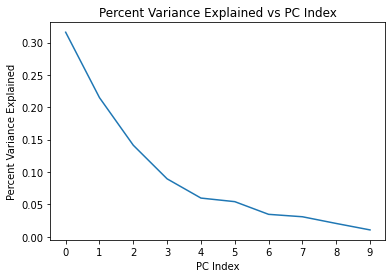

In [47]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# a) PCA

In [48]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

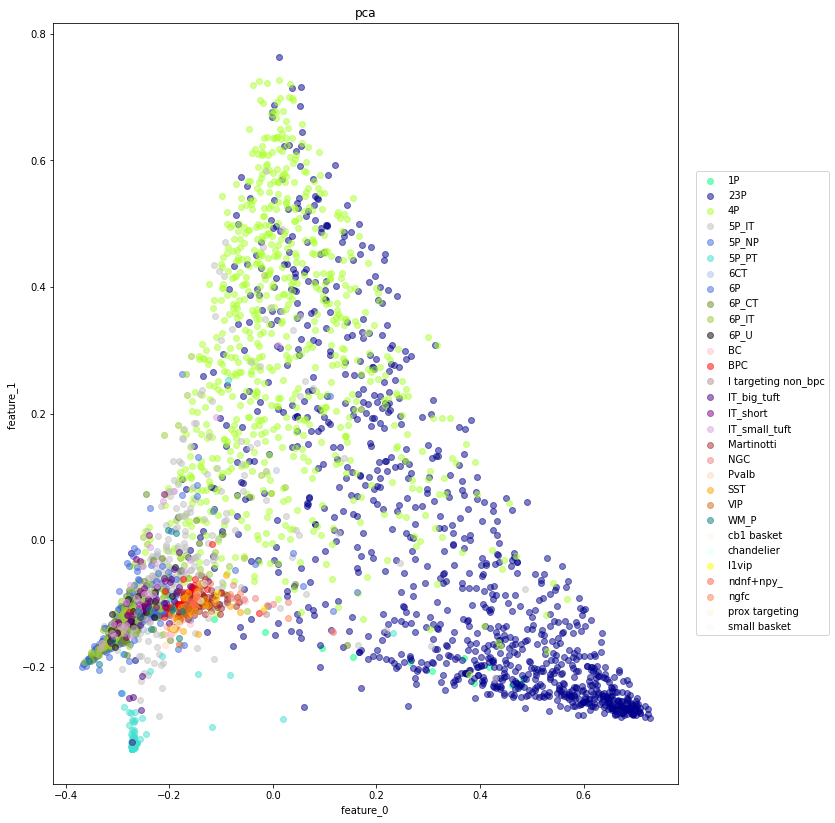

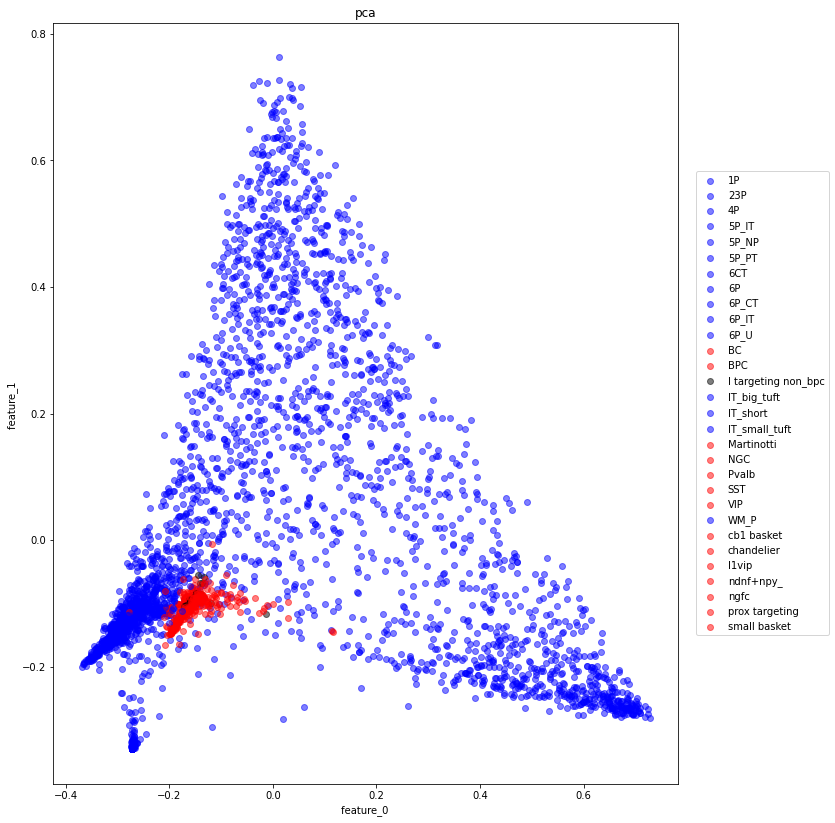

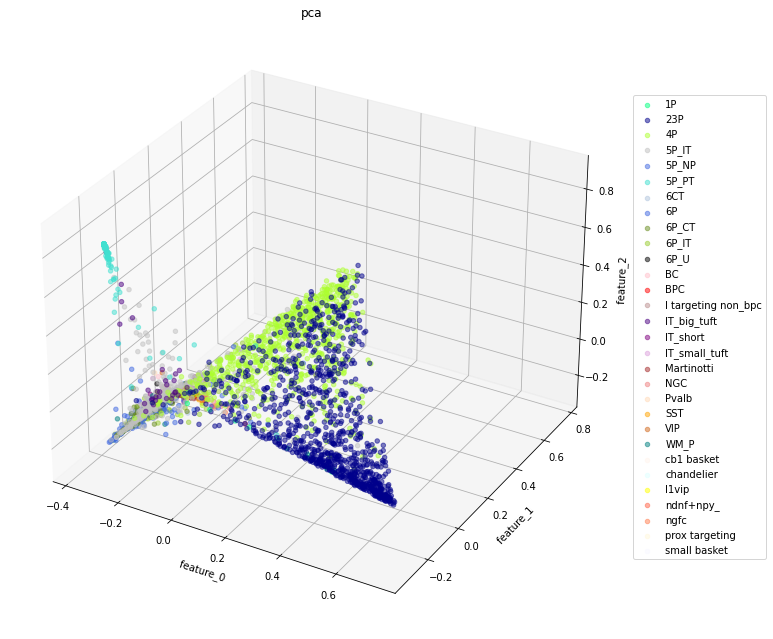

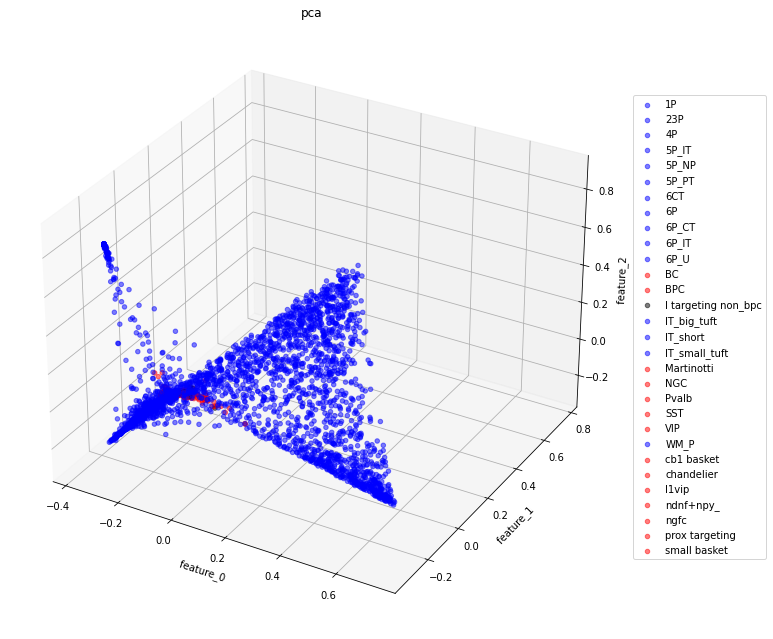

In [49]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "pca",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
)

# b) UMAP (0.5)

In [50]:
X_trans = dru.dimensionality_reduction_by_method(
        method="UMAP",
        X = X_input,
        n_components =2,
        min_dist = 0.5,
        )

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9100. The TBB threading layer is disabled.
  warnings.warn(problem)


In [51]:
method = "UMAP"

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

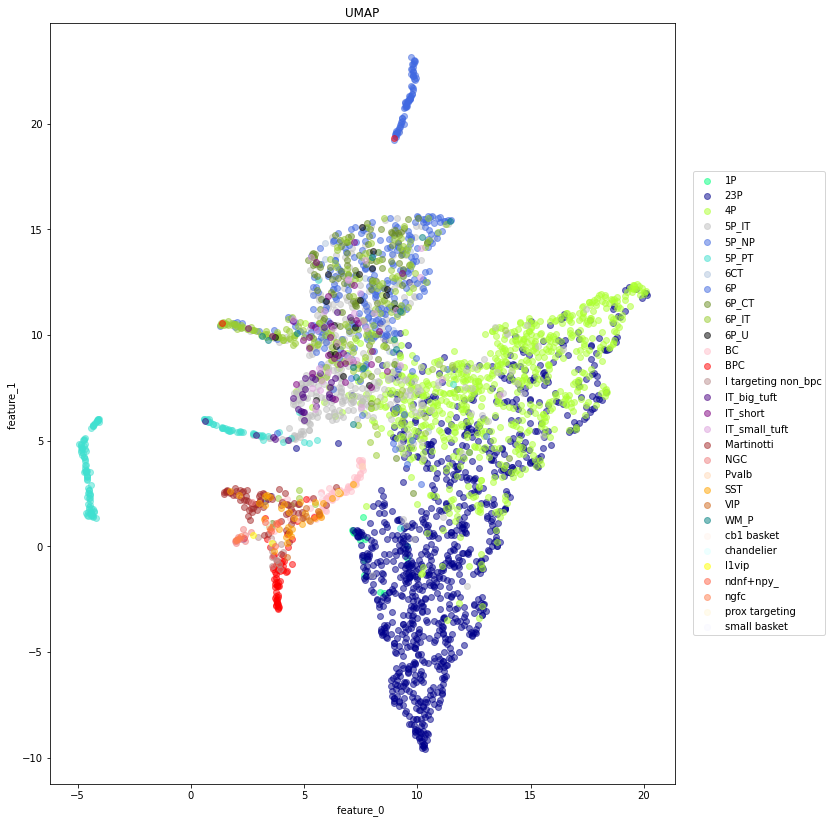

In [52]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = 2,
                title=method,
            )

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

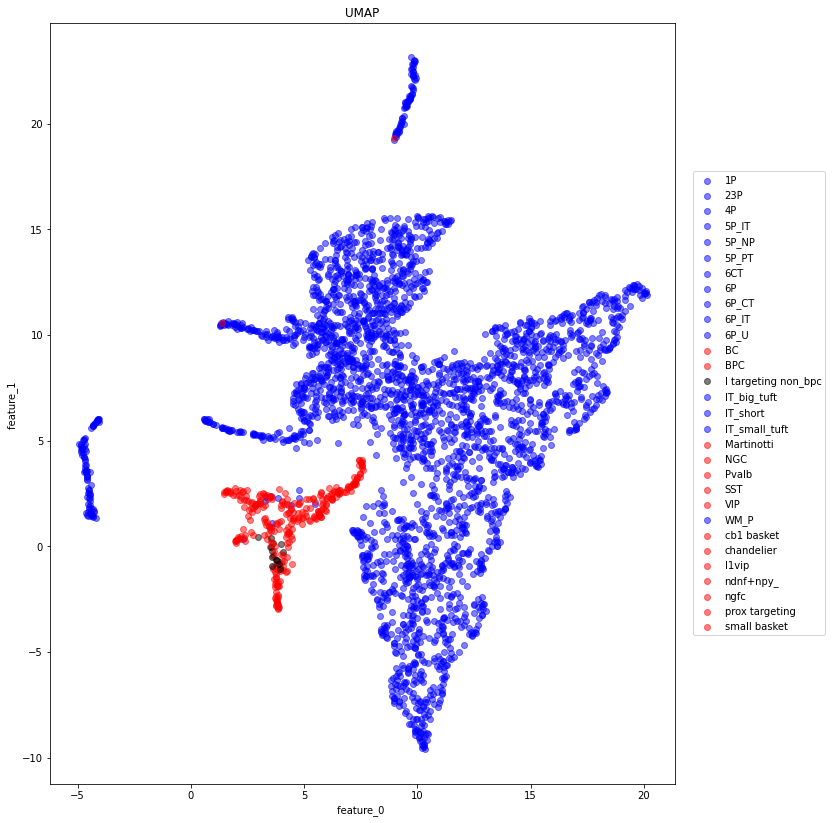

In [53]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.e_i_color_dict(),
                ndim = 2,
                title=method,
            )

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

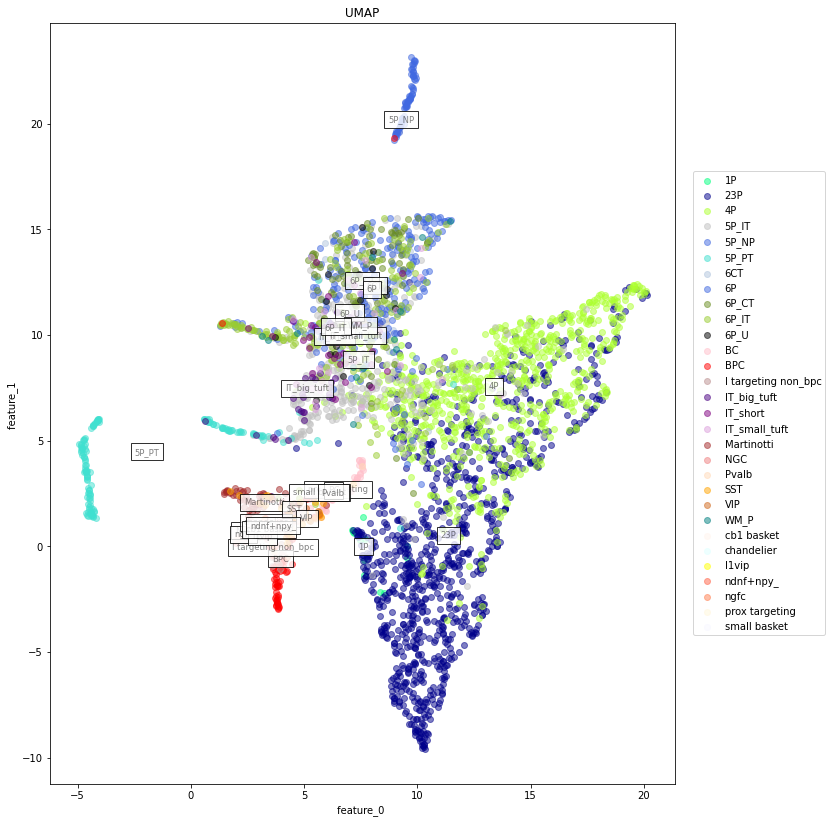

In [54]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = 2,
                title=method,
    use_labels_as_text_to_plot=True
            )

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.5,
    #plot_kwargs=dict(use_labels_as_text_to_plot = True)
)

# b) UMAP (0.2)

In [ ]:
sys.path.append("/meshAfterParty/meshAfterParty/")
import datajoint_utils as du
import cell_type_utils as ctu

In [ ]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.2,
)

# tsne

In [ ]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "tsne",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    #min_dist = 0.2,
)

# Running a Classification and then a confusion matrix

In [55]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,cell_type
0,0.005112,0.002517,1.060453e-01,0.403461,0.208483,0.021397,0.001334,0.011457,0.016365,0.020602,...,0.001718,0.001387,0.004347,0.003369,0.002683,0.001716,0.007948,0.005370,0.001702,4P
1,0.004875,0.017190,3.209244e-01,0.291885,0.067737,0.004231,0.002191,0.005194,0.041046,0.011647,...,0.004040,0.010780,0.005242,0.006386,0.010699,0.010279,0.008553,0.005291,0.003046,23P
2,0.003810,0.002767,9.109420e-02,0.070450,0.098598,0.008068,0.006661,0.081931,0.264857,0.134744,...,0.002528,0.016624,0.004211,0.005306,0.008717,0.004643,0.013502,0.004069,0.006000,5P_IT
3,0.000620,0.000711,2.486239e-04,0.000786,0.052525,0.002363,0.014785,0.001069,0.057194,0.011470,...,0.000273,0.004323,0.000685,0.000189,0.000100,0.000102,0.000012,0.000678,0.000898,IT_short
4,0.003404,0.081123,4.140968e-01,0.042050,0.019026,0.001806,0.000217,0.013879,0.048154,0.006096,...,0.005918,0.005681,0.003127,0.011850,0.009563,0.059513,0.028799,0.003643,0.001097,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,0.001373,0.005347,7.628497e-02,0.840796,0.020975,0.000297,0.000467,0.001556,0.002719,0.001200,...,0.001705,0.000650,0.000983,0.002078,0.000253,0.000833,0.000538,0.001485,0.000714,4P
3327,0.000467,0.007284,1.895066e-03,0.001210,0.002232,0.000694,0.000730,0.000320,0.000305,0.000117,...,0.012833,0.002878,0.000830,0.002531,0.001086,0.046364,0.001292,0.000513,0.004424,Unsure
3328,0.000122,0.000037,9.659121e-07,0.000372,0.080772,0.668018,0.000223,0.002852,0.020478,0.000867,...,0.000258,0.007847,0.000143,0.000200,0.000019,0.000138,0.000028,0.000135,0.001232,5P_NP
3329,0.002489,0.011231,3.453891e-03,0.012158,0.090221,0.007901,0.024041,0.006493,0.041107,0.003485,...,0.004415,0.022119,0.002297,0.001815,0.000753,0.002204,0.000146,0.002766,0.012307,6P


In [56]:
import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,cell_type,cell_type_predicted
0,0.005112,0.002517,1.060453e-01,0.403461,0.208483,0.021397,0.001334,0.011457,0.016365,0.020602,...,0.001387,0.004347,0.003369,0.002683,0.001716,0.007948,0.005370,0.001702,4P,4P
1,0.004875,0.017190,3.209244e-01,0.291885,0.067737,0.004231,0.002191,0.005194,0.041046,0.011647,...,0.010780,0.005242,0.006386,0.010699,0.010279,0.008553,0.005291,0.003046,23P,23P
2,0.003810,0.002767,9.109420e-02,0.070450,0.098598,0.008068,0.006661,0.081931,0.264857,0.134744,...,0.016624,0.004211,0.005306,0.008717,0.004643,0.013502,0.004069,0.006000,5P_IT,6P
3,0.000620,0.000711,2.486239e-04,0.000786,0.052525,0.002363,0.014785,0.001069,0.057194,0.011470,...,0.004323,0.000685,0.000189,0.000100,0.000102,0.000012,0.000678,0.000898,IT_short,6P_IT
4,0.003404,0.081123,4.140968e-01,0.042050,0.019026,0.001806,0.000217,0.013879,0.048154,0.006096,...,0.005681,0.003127,0.011850,0.009563,0.059513,0.028799,0.003643,0.001097,23P,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,0.003096,0.005830,3.455012e-01,0.485498,0.031858,0.004155,0.000921,0.006026,0.006065,0.001820,...,0.002845,0.002340,0.003382,0.003993,0.005290,0.001898,0.003396,0.002951,4P,4P
3326,0.001373,0.005347,7.628497e-02,0.840796,0.020975,0.000297,0.000467,0.001556,0.002719,0.001200,...,0.000650,0.000983,0.002078,0.000253,0.000833,0.000538,0.001485,0.000714,4P,4P
3328,0.000122,0.000037,9.659121e-07,0.000372,0.080772,0.668018,0.000223,0.002852,0.020478,0.000867,...,0.007847,0.000143,0.000200,0.000019,0.000138,0.000028,0.000135,0.001232,5P_NP,5P_NP
3329,0.002489,0.011231,3.453891e-03,0.012158,0.090221,0.007901,0.024041,0.006493,0.041107,0.003485,...,0.022119,0.002297,0.001815,0.000753,0.002204,0.000146,0.002766,0.012307,6P,6P_IT


In [57]:
accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
accuracy

0.640289942615524

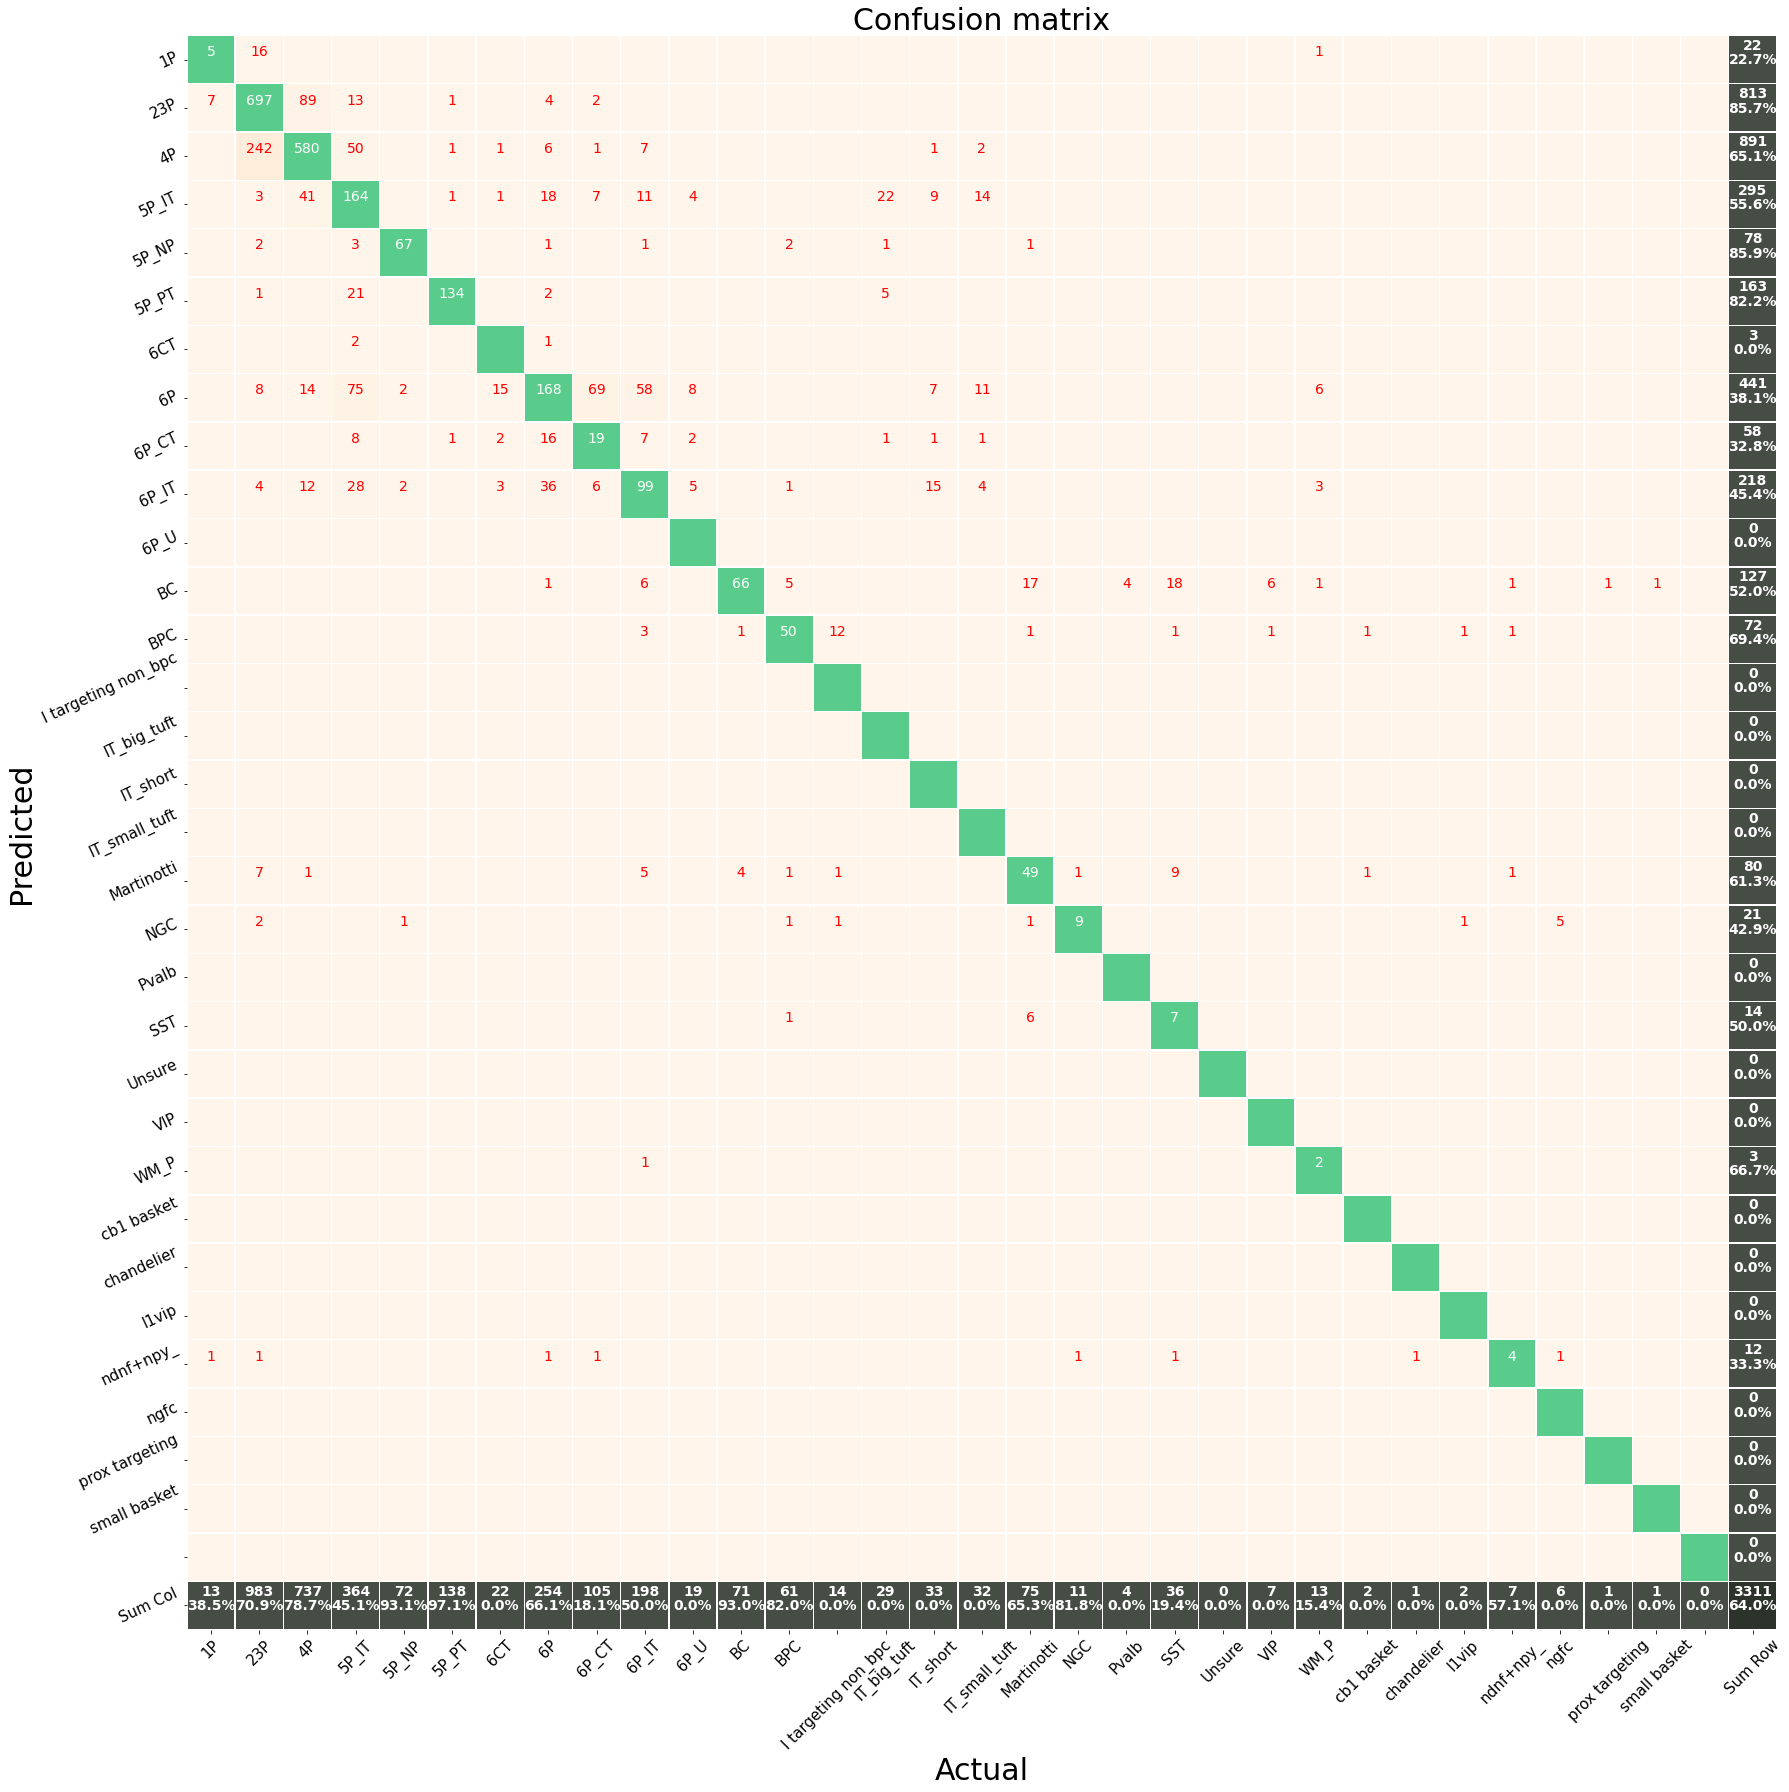

In [58]:
import statistics_visualizations as sviz
sviz.plot_pretty_confusion_matrix(
    y_true = df_labeled["cell_type"],
    y_pred = df_labeled["cell_type_predicted"],
    labels = list(cell_type_map.keys()),
    figsize=(25,25),
    cell_fontsize = 14,
    ticklabel_fontsize=15)

# Confusion matrix of EI

In [59]:
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]
df_labeled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,cell_type,cell_type_predicted,e_i_label,e_i_predicted
0,0.005112,0.002517,1.060453e-01,0.403461,0.208483,0.021397,0.001334,0.011457,0.016365,0.020602,...,0.003369,0.002683,0.001716,0.007948,0.005370,0.001702,4P,4P,excitatory,excitatory
1,0.004875,0.017190,3.209244e-01,0.291885,0.067737,0.004231,0.002191,0.005194,0.041046,0.011647,...,0.006386,0.010699,0.010279,0.008553,0.005291,0.003046,23P,23P,excitatory,excitatory
2,0.003810,0.002767,9.109420e-02,0.070450,0.098598,0.008068,0.006661,0.081931,0.264857,0.134744,...,0.005306,0.008717,0.004643,0.013502,0.004069,0.006000,5P_IT,6P,excitatory,excitatory
3,0.000620,0.000711,2.486239e-04,0.000786,0.052525,0.002363,0.014785,0.001069,0.057194,0.011470,...,0.000189,0.000100,0.000102,0.000012,0.000678,0.000898,IT_short,6P_IT,excitatory,excitatory
4,0.003404,0.081123,4.140968e-01,0.042050,0.019026,0.001806,0.000217,0.013879,0.048154,0.006096,...,0.011850,0.009563,0.059513,0.028799,0.003643,0.001097,23P,23P,excitatory,excitatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,0.003096,0.005830,3.455012e-01,0.485498,0.031858,0.004155,0.000921,0.006026,0.006065,0.001820,...,0.003382,0.003993,0.005290,0.001898,0.003396,0.002951,4P,4P,excitatory,excitatory
3326,0.001373,0.005347,7.628497e-02,0.840796,0.020975,0.000297,0.000467,0.001556,0.002719,0.001200,...,0.002078,0.000253,0.000833,0.000538,0.001485,0.000714,4P,4P,excitatory,excitatory
3328,0.000122,0.000037,9.659121e-07,0.000372,0.080772,0.668018,0.000223,0.002852,0.020478,0.000867,...,0.000200,0.000019,0.000138,0.000028,0.000135,0.001232,5P_NP,5P_NP,excitatory,excitatory
3329,0.002489,0.011231,3.453891e-03,0.012158,0.090221,0.007901,0.024041,0.006493,0.041107,0.003485,...,0.001815,0.000753,0.002204,0.000146,0.002766,0.012307,6P,6P_IT,excitatory,excitatory


In [60]:
df_labeled_filt = df_labeled.query("e_i_label != 'unknown'")

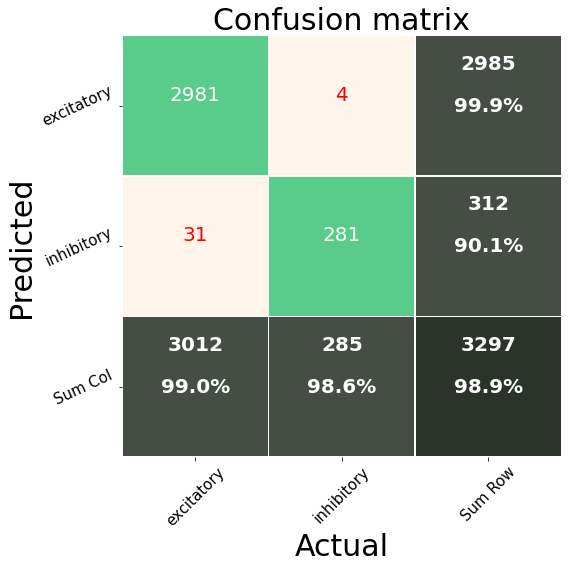

In [61]:
import statistics_visualizations as sviz
sviz.plot_pretty_confusion_matrix(
    y_true = df_labeled["e_i_label"],
    y_pred = df_labeled["e_i_predicted"],
    labels = list(df_labeled_filt["e_i_label"].unique()),
    figsize=(8,8),
    #cell_fontsize = 15,
    #ticklabel_fontsize=15
)

# Computing the Test Accuracy

In [62]:
all_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.6283987915407855
e_i_label test accuracy: 0.9833836858006042


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [63]:
all_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.6193353474320241
e_i_label test accuracy: 0.9788519637462235


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
